# Phase Slope Index (PSI)

Saleh Rezaeiravesh, saleh.rezaeiravesh@manchester.ac.uk
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../core/')
from synData import tsGen3
from psi import bi_psi, mv_psi
from te import bi_te

## Bivariate PSI

PSI introduced by [Nolte et al., 2008](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.234101) computes the **direction of frequency-specific interactions** between time series. A positive aspect of PSI is that it vanishes for linear mixing of independent time series (remoes the artificial instantaneous coinnectivities between time series; proof in the appendix of [Basti et al., 2018](https://www.sciencedirect.com/science/article/pii/S1053811918301897)). 

$$
\psi_{x,y} = Im \left( \sum_{f\in F} \frac{S_{xy}(f+\delta f)}{\sqrt{S_{xx}(f+\delta f)S_{yy}(f+\delta f)}} \frac{S^*_{xy}(f)}{\sqrt{S_{xx}(f)S_{yy}(f)}}\right)
$$

where, 
* $F$ the set of frequencies of interest
* $Im$ is the imaginary part.
* $S_{xy}(f)$ is the cross-spectral density of $x$ and $y$ at frequency $f$.
* $S_{xy}^{*}(f)$ is the complex conjugate of $S_{xy}(f)$.
* $\delta f$ is the frequency resolution (the step size between frequency bins).
  
**Interpretation:**
* If $\psi_{xy}>0$: $x$ consistently leading $y$.
* If $\psi_{xy}<0$: $y$ consistently leading $x$.

**Note:**
* The set of $F$ contains the frequencies of interest. Therefore, PSI allows for meausing directionality of interactions at a set of specific frequenccies.
* PSI is **linear**. However in [Nolte et al., 2010](https://proceedings.mlr.press/v6/nolte10a.html) it was shown that the PSI acts better than Granger causality, althugh PSI may fail in capturing some non-linear interactions. 

## Multivariate PSI

Multivariate PSI was introduced by [Basti et al., 2018](https://www.sciencedirect.com/science/article/pii/S1053811918301897). Say we have two groups of time series $\mathbf{X}$ and $\mathbf{Y}$, which contain $n$ samples of $nX$ and $nY$ time series, respectively. mPSI is a scalar, and shows the directionality of information between $\mathbf{X}$ and $\mathbf{Y}$:
* if $mPSI (\mathbf{X},\mathbf{Y})>0$ then information go from $\mathbf{X}$ to $\mathbf{Y}$.
* if $mPSI (\mathbf{X},\mathbf{Y})<0$ then information go from $\mathbf{Y}$ to $\mathbf{X}$.

**Note:**
Bivariate PSI  and multivariate PSI for a pair of time series, may not provide the same results. The fact is that the bivariate PSI is computed based on the Cross spectral desnity, but the mPSI relies on the inverse of Cross spectral density: 

$$
mPSI \propto tr[S^{-1}(f)S(f+\delta f)]
$$

* Multivariate PSY works with the inverse cross-spectral density (precision matrix).
* It is not pair-specific, it’s a global system measure of net directionality.
* Even with 2 signals, it’s not equivalent to the bivariate PSI formula, because:
  * In bivariate PSI, you’re looking at the slope of the cross-spectral phase directly.
  * In multivariate PSI, you’re looking at the inverse CSD, which mixes auto- and cross-spectral terms in a different way.

## Read time series data

In [149]:
dataType = 'tsGen3'  #'supCanyonPOD' or 'tsGen3'

In [150]:
if dataType == 'supCanyonPOD': #POD temporal coefficients of the step-up canyon case
   db = np.load('./data/blsF1_symm_full_redone_100Modes__singular_data.npz')
   print(db.keys())
   t = db['time_array']
   u = db['v_singular_vectors']   #POD temporal coefficients
   print(t.shape,u.shape)
elif dataType == 'tsGen3':   #synthetic data
   u = tsGen3(n=2000).T 
   t=np.arange(u.shape[1]) 
   print(u.shape)

(4, 2000)


## Compute bivariate PSI and compare it to TE

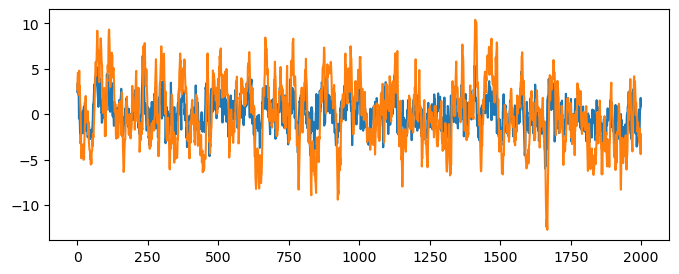

In [151]:
x = u[0,:]
y = u[1,:]

plt.figure(figsize=(8,3))
plt.plot(t,x)
plt.plot(t,y)
plt.show()

In [152]:
psi_ = bi_psi(x,y).comp()
print(psi_)

2.4364559076630745


If `psi_` is positive, $x$ consistently leads $y$

Now, let's compare bivariate PSI with bivariate TE

In [157]:
lagList_=np.arange(1,5,1)

te_kde_xy=[]
te_kde_yx=[]
te_ksg_xy=[]
te_ksg_yx=[]

for lag in lagList_:   
    te1_ = bi_te(x, y, lag).kde()
    te_kde_xy.append(te1_)
    te1_ = bi_te(x, y, embDim=lag).ksg(k=5)
    te_ksg_xy.append(te1_)
        
    te2_ = bi_te(y, x, lag).kde()
    te_kde_yx.append(te2_)
    te3_ = bi_te(y, x, embDim=lag).ksg(k=5)
    te_ksg_yx.append(te3_)
    
te_kde_xy = np.array(te_kde_xy)    
te_kde_yx = np.array(te_kde_yx)        
te_ksg_xy = np.array(te_ksg_xy)    
te_ksg_yx = np.array(te_ksg_yx)    

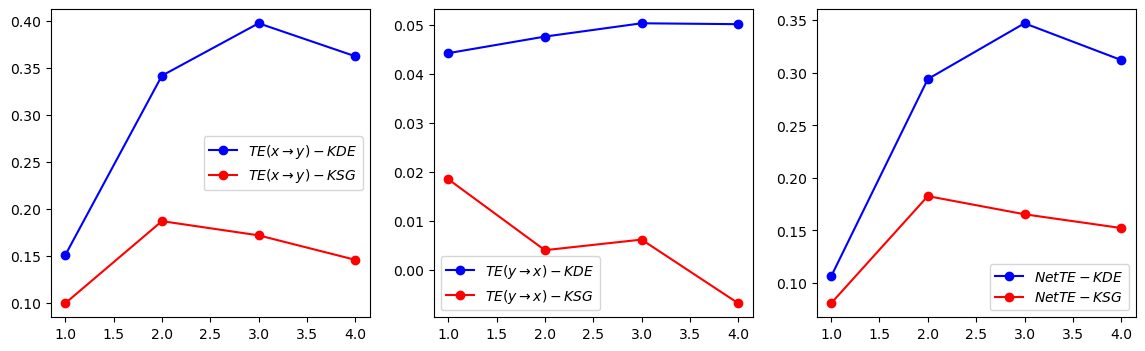

In [158]:
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.plot(lagList_,te_kde_xy,'-ob',label=r'$TE(x\to y) - KDE$')    
plt.plot(lagList_,te_ksg_xy,'-or',label=r'$TE(x\to y) - KSG$')    
plt.legend(loc='best')
plt.subplot(132)
plt.plot(lagList_,te_kde_yx,'-ob',label=r'$TE(y\to x) - KDE$')    
plt.plot(lagList_,te_ksg_yx,'-or',label=r'$TE(y\to x) - KSG$')    
plt.legend(loc='best')
plt.subplot(133)
plt.plot(lagList_,te_kde_xy-te_kde_yx,'-ob',label=r'$Net TE - KDE$')    
plt.plot(lagList_,te_ksg_xy-te_ksg_yx,'-or',label=r'$Net TE - KSG$')    
plt.legend(loc='best')
plt.show()

**Conclusion:** It seems bivariate PSI and Net Maximum TE at lag=1 may be consistent for some time series. 
Noting that PSI is linear measure, any difference with maxTE can be attributed to the non-linear effects. 
 

**Conclusion:** For the linear VAR(2) model `tsGen3`, $x_1$ is causing the others. Therefore PSI and NET TE should agree on this. 
For instance for $x=x_1$ and $x=x_2$, we should see positive PSI and net TE, meaning that information transfer from $x_1$ to $x_2$.

## Multivariate PSI

We can divide the time series into two sets $\mathbf{X}$ and $\mathbf{Y}$. Then we can measure the information direction between  $\mathbf{X}$ and $\mathbf{Y}$.

In [140]:
X = np.vstack((u[1,:])).T
Y = np.vstack((u[3,:])).T

print(X.shape,Y.shape)

(1, 735) (1, 735)


In [141]:
mpsi_ = mv_psi(X,Y).comp()

In [142]:
print(mpsi_)

-3.034869441119765


In [129]:
X = np.vstack((u[12,:],u[13,:],u[14,:]))
Y = np.vstack((u[11,:])).T
mpsi_ = mv_psi(X,Y).comp()
print(mpsi_)

4.428093709123484
